In [2]:
import torch, time, pickle,os
import torch_geometric as tg
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp
import networkx as nx

In [3]:
os.listdir(osp.expanduser('~/../../scratch/gpfs/cj1223/GraphStorage/'))

['vlarge_all_4t_z1.0_standard_quant',
 'vlarge_all_4t_z0.3_quantile_raw',
 'vlarge_4t_quantile_raw_redshift_75_all',
 'vlarge_all_4t_z1.0_quantile_raw',
 'vlarge_all_4t_z0.3_None',
 'vlarge_all_4t_z3.0_quantile_raw',
 'vlarge_all_4t_z2.0_standard_quant',
 'vlarge_all_4t_z0.8_quantile_raw',
 'tvt_idx',
 'vlarge_all_4t_z2.0_None',
 'redshift_scan_0',
 'testid_all_4t_z2.0_None',
 'vlarge_all_4t_z0.0_quantile_stand',
 'vlarge_all_multi_try1',
 'vlarge_4t_quantile_raw_redshift_99_all',
 'vlarge_all_4t_z2.0_quantile_raw',
 'vlarge_all_4t_z0.0_standard_quant',
 'vlarge_all_4t_z0.5_quantile_quant',
 'vlarge_4t_quantile_raw_redshift_50_all',
 'vlarge_all_4t_z2.0_quantile_stand',
 'vlarge_all_4t_z1.0_quantile_quant',
 'transformers',
 'vlarge_all_4t_z0.0_standard_raw',
 'vlarge_all_4t_quantile_raw_final',
 'vlarge_all_4t_z0.5_standard_stand',
 'vlarge_all_4t_z1.8_quantile_raw',
 'vlarge_all_4t_z0.5_standard_quant',
 'vlarge_all_4t_zall_quantile_raw_trainandtest',
 'vlarge_all_4t_z0.0_quantile_ra

In [4]:
case=f'testid_all_4t_z{0.0}_None'
data0=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
meta0=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/meta.pkl', 'rb'))
case='testid_all_4t_z2.0_None'
data1=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
meta1=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/meta.pkl', 'rb'))


In [15]:
len(np.hstack(meta0['extra']))
ls=np.hstack(meta0['extra'])

In [21]:
lss = []
for l in ls:
    lss.append(int(l[0,0]))

In [23]:
with open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/haloids.pkl'), 'wb') as handle:
    pickle.dump(lss, handle)

In [6]:
data0.append(data1)

In [7]:
metaz0=np.hstack(meta0['extra'])
metaz2=np.hstack(meta1['extra'])

In [7]:
kls, jls = [], []
kls.append(0)
jls.append(0)
for metaz0, metaz1 in zip(meta0['extra'], meta1['extra']):
    kls.append(len(metaz0))
    jls.append(len(metaz1))
    
# @numba.jit(nopython=True, parallel=True)
def run(metaz0, metaz1):
    ks, js =[],[]
    for k in tqdm(range(len(metaz0))):
        for j in range(len(metaz1)):
            s=metaz1[j][0,0] in metaz0[k][:,0]
#             s=np.any(np.in1d(metaz2[j][:,0], metaz0[k][:,0]))
#             s=np.any(np.isin(metaz2[j][:,0], metaz0[k][:,0]))
    
            if s:
                ks.append(k)
                js.append(j)
    return np.array(ks), np.array(js)

kss, jss = [], []
for metaz0, metaz1 in zip(meta0['extra'], meta1['extra']):
    ks, js = run(metaz0, metaz1) 
    kss.append(ks)
    jss.append(js)
    
kss, jss = np.array(kss), np.array(jss)   

kss+=np.cumsum(kls)[:-1]
jss+=np.cumsum(jls)[:-1]

100%|██████████████████████████████████████████████████████████| 1339/1339 [00:07<00:00, 182.15it/s]
/tmp/ipykernel_19449/358635189.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kss, jss = np.array(kss), np.array(jss)


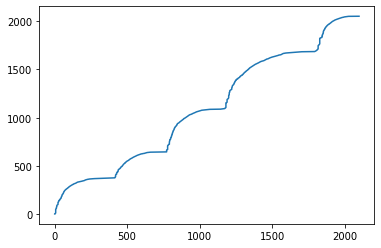

In [8]:
plt.plot(np.hstack(kss), np.hstack(jss))

In [8]:
case=f'vlarge_all_4t_z0.0'

## meta and data coming from different places

data0=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}_quantile_raw/data.pkl', 'rb'))
meta0=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}_None/meta.pkl', 'rb'))
# metaz0=np.hstack(meta0['extra'])
l=len(data0)

In [10]:
train=np.arange(l)[:int(l*0.8)]
test=np.arange(l)[int(l*0.8):]

datatrain=data0[:int(l*0.8)]
datatest=data0[int(l*0.8):]

trains=[datatrain]
tests=[datatest]
marg=300
def run(metaz0, metaz1):
    ks, js =[],[]
    for k in range(len(metaz0)):
        for j in range(max(0, k-marg), min(len(metaz1), k+marg)):
#         for j in range(len(metaz1)):
            
#             s=metaz1[j][0,0] in metaz0[k][:,0]
            s=np.any(np.in1d(metaz1[j][:,0], metaz0[k][:,0]))
#             s=np.any(np.isin(metaz2[j][:,0], metaz0[k][:,0]))

            if s:
                ks.append(k)
                js.append(j)
    return np.array(ks), np.array(js)

def find_missing(lst, ma):
    return [x for x in range(lst[0], ma) 
                               if x not in lst]
    

In [23]:
for z in [0.5,1.0,2.0]:
# for z in [2.0]:

    case=f'vlarge_all_4t_z{z}'
    data1=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}_quantile_raw/data.pkl', 'rb'))
    meta1=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}_None/meta.pkl', 'rb'))

    kls, jls = [], []
    kls.append(0)
    jls.append(0)
    for metaz0, metaz1 in zip(meta0['extra'], meta1['extra']):
        kls.append(len(metaz0))
        jls.append(len(metaz1))

    # @numba.jit(nopython=True, parallel=True)


    kss, jss = [], []
    for metaz0, metaz1 in tqdm(zip(meta0['extra'], meta1['extra']), total=len(meta0['extra'])):
        ks, js = run(metaz0, metaz1) 
        kss.append(ks)
        jss.append(js)

    kss, jss = np.array(kss, dtype=object), np.array(jss, dtype=object)   

    kss+=np.cumsum(kls)[:-1]
    jss+=np.cumsum(jls)[:-1]
    jss=np.hstack(jss)
    kss=np.hstack(kss)

    jtrain=jss[kss<len(train)]
    jtest=find_missing(jtrain, len(data1))
    data1train=[data1[j] for j in jtrain]
    data1test=[data1[j] for j in jtest]
    trains.append(data1train)
    tests.append(data1test)
    q=int(0.8*(len(tests[-1])+len(trains[-1]))-len(trains[-1]))
    trains[-1]+=tests[-1][:q]
    tests[-1]=tests[-1][q:]

100%|███████████████████████████████████████████████████████████| 125/125 [1:18:36<00:00, 37.73s/it]


In [27]:
for tr, te in zip(trains, tests):
    print(len(tr)/len(te), len(tr), len(te))

3.99990809668229 87046 21762
3.9998376623376624 98556 24640
3.999960494607514 101251 25313
3.9998730212477778 94501 23626


In [28]:
trainall=[]
testall=[]
for tr, te in zip(trains, tests):
    trainall+=tr
    testall+=te

In [30]:
len(trainall)/len(testall)

3.999895113330047

In [31]:
case='vlarge_all_4t_zall_quantile_raw'
print("Saving dataset")
if not osp.exists(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}')):
    os.mkdir(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}'))

with open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data_train.pkl'), 'wb') as handle:
    pickle.dump(trainall, handle)
with open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{case}/data_test.pkl'), 'wb') as handle:
    pickle.dump(testall, handle)

Saving dataset


In [33]:
os.listdir(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/'))

['vlarge_all_4t_z1.0_standard_quant',
 'vlarge_4t_quantile_raw_redshift_75_all',
 'vlarge_all_4t_z1.0_quantile_raw',
 'vlarge_all_4t_z2.0_standard_quant',
 'vlarge_all_4t_z2.0_None',
 'redshift_scan_0',
 'testid_all_4t_z2.0_None',
 'vlarge_all_4t_z0.0_quantile_stand',
 'vlarge_all_multi_try1',
 'vlarge_4t_quantile_raw_redshift_99_all',
 'vlarge_all_4t_z2.0_quantile_raw',
 'vlarge_all_4t_z0.0_standard_quant',
 'vlarge_all_4t_z0.5_quantile_quant',
 'vlarge_4t_quantile_raw_redshift_50_all',
 'vlarge_all_4t_z2.0_quantile_stand',
 'vlarge_all_4t_z1.0_quantile_quant',
 'transformers',
 'vlarge_all_4t_z0.0_standard_raw',
 'vlarge_all_4t_quantile_raw_final',
 'vlarge_all_4t_z0.5_standard_stand',
 'vlarge_all_4t_z0.5_standard_quant',
 'vlarge_all_4t_z0.0_quantile_raw',
 'old',
 'vlarge_all_4t_z1.0_None',
 'vlarge_all_4t_z1.0_standard_stand',
 'vlarge_all_4t_z2.0_standard_raw',
 'vlarge_4t_quantile_raw_redshift_95_all',
 'testid_all_4t_z0.0_None',
 'vlarge_all_4t_z0.5_standard_raw',
 'vlarge_all

In [21]:
a=[[1,2,3,4,5],[1,2,3,4,5]]
b=[[5,3,3,4,5],[9,1,3,4,5]]

In [22]:
a[-1]+=b[-1][:2]
b[-1]=b[-1][2:]
b, a

([[5, 3, 3, 4, 5], [3, 4, 5]], [[1, 2, 3, 4, 5], [1, 2, 3, 4, 5, 9, 1]])

In [49]:
l=len(np.hstack(meta0['extra']))
l, len(data0)
train=np.arange(l)[:int(l*0.8)]
test=np.arange(l)[int(l*0.8):]

datatrain=data0[:int(l*0.8)]
datatest=data0[int(l*0.8):]

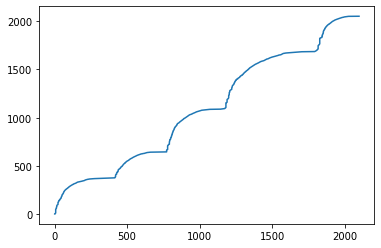

In [13]:
plt.plot(ks, js)

In [22]:
case=f'vlarge_all_4t_z0.0'

## meta and data coming from different places

data0=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}_quantile_raw/data.pkl', 'rb'))
meta0=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}_None/meta.pkl', 'rb'))
metaz0=np.hstack(meta0['extra'])
l=len(metaz0)

train=np.arange(l)[:int(l*0.8)]
test=np.arange(l)[int(l*0.8):]

datatrain=data0[:int(l*0.8)]
datatest=data0[int(l*0.8):]
marg=5000
for z in [0.5,1.0,2.0]:
# for z in [2.0]:

    case=f'vlarge_all_4t_z{z}'
    data1=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}_quantile_raw/data.pkl', 'rb'))
    meta1=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}_None/meta.pkl', 'rb'))
    metaz1=np.hstack(meta1['extra'])
    ks, js =[],[]
    for k in tqdm(range(len(metaz0)//5)):
        for j in range(max(0, int(k*0.95)-10), min(len(metaz1), int(k*1.05)+10)):
#             s=np.sum(np.isin(metaz1[j][:,0], metaz0[k][:,0]))/len(metaz1[j])
            s=np.any(np.isin(metaz1[j][:,0], metaz0[k][:,0]))

            if s:
                ks.append(k)
                js.append(j)
    js=np.array(js)
    ks=np.array(ks)

100%|█████████████████████████████████████████████████████████| 21761/21761 [47:25<00:00,  7.65it/s]


NameError: name 'find_missing' is not defined

In [7]:
# cases = ['vlarge_all_4t_z0.0_quantile_raw', 'vlarge_all_4t_z0.5_quantile_raw', 'vlarge_all_4t_z1.0_quantile_raw', 'vlarge_all_4t_z2.0_quantile_raw']
# metas = ['vlarge_all_4t_z0.0_None', 'vlarge_all_4t_z0.5_None', 'vlarge_all_4t_z1.0_None', 'vlarge_all_4t_z2.0_None']
# i=0
# case, meta=cases[i], metas[i]
# data0=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
# meta0=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{meta}/meta.pkl', 'rb'))
# i=3
# case, meta=cases[i], metas[i]
# data1=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
# meta1=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{meta}/meta.pkl', 'rb'))
# sums=[]
# ks, js =[],[]
# for k in tqdm(range(len(meta0['extra']))):
#     for j in range(len(meta1['extra'])):
#         s=np.sum(np.isin(meta1['extra'][j][:,0], meta0['extra'][k][:,0]))/len(meta1['extra'][j])
#         if s>0:
#             sums.append(s)
#             ks.append(k)
#             js.append(j)
# js=np.array(js)
# ks=np.array(ks)